In [14]:
#Import necessary packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from pathlib import Path
import os.path

import plotly.express as ex
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [15]:
image_dir = Path("../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset")

In [16]:
image_dir

PosixPath('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')

In [17]:
# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
image_df['Label'] = image_df['Label'].apply(lambda x: np.NaN if x[-2:] == 'GT' else x)
image_df = image_df.dropna(axis=0)

In [18]:
image_df

,Filepath,Label
0,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
1,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
2,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
3,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
4,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
...,...,...
16995,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream
16996,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream
16997,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream
16998,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream


In [19]:
image_df['Label'].unique()

array(['Hourse Mackerel', 'Black Sea Sprat', 'Sea Bass', 'Red Mullet',
       'Trout', 'Striped Red Mullet', 'Shrimp', 'Gilt-Head Bream',
       'Red Sea Bream'], dtype=object)

In [20]:
image_df['Label'].value_counts()

Trout                 1000
Sea Bass              1000
Gilt-Head Bream       1000
Shrimp                1000
Red Mullet            1000
Hourse Mackerel       1000
Black Sea Sprat       1000
Red Sea Bream         1000
Striped Red Mullet    1000
Name: Label, dtype: int64

In [21]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [22]:
train_df

,Filepath,Label
3651,../input/a-large-scale-fish-dataset/Fish_Datas...,Black Sea Sprat
4176,../input/a-large-scale-fish-dataset/Fish_Datas...,Sea Bass
11919,../input/a-large-scale-fish-dataset/Fish_Datas...,Striped Red Mullet
94,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
551,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
...,...,...
4895,../input/a-large-scale-fish-dataset/Fish_Datas...,Sea Bass
15813,../input/a-large-scale-fish-dataset/Fish_Datas...,Gilt-Head Bream
905,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
11192,../input/a-large-scale-fish-dataset/Fish_Datas...,Striped Red Mullet


## Loading the images using Image Data Generator

In [23]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [24]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5040 validated image filenames belonging to 9 classes.
Found 1260 validated image filenames belonging to 9 classes.
Found 2700 validated image filenames belonging to 9 classes.


In [25]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [27]:
pretrained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [28]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(9, activation='softmax')(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
158/158 [==============================] - 158s 968ms/step - loss: 0.6058 - accuracy: 0.8219 - val_loss: 0.0260 - val_accuracy: 0.9937
Epoch 2/100
158/158 [==============================] - 69s 438ms/step - loss: 0.0164 - accuracy: 0.9961 - val_loss: 0.0222 - val_accuracy: 0.9929
Epoch 3/100
158/158 [==============================] - 70s 441ms/step - loss: 0.0070 - accuracy: 0.9987 - val_loss: 0.0086 - val_accuracy: 0.9976
Epoch 4/100
158/158 [==============================] - 69s 435ms/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 0.0057 - val_accuracy: 0.9976
Epoch 5/100
158/158 [==============================] - 69s 436ms/step - loss: 6.7436e-04 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 0.9984
Epoch 6/100
158/158 [==============================] - 69s 436ms/step - loss: 4.7341e-04 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 0.9976
Epoch 7/100
158/158 [==============================] - 69s 436ms/step - loss: 2.8892e-04 - accuracy: 1.0000 - val_l

In [30]:
import plotly
from plotly import version
print (version)

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

<module 'plotly.version' from '/opt/conda/lib/python3.7/site-packages/plotly/version.py'>


In [35]:
import plotly.express as px
fig = px.line(history.history,
             y=['loss', 'val_loss'],
             labels= {'index': 'Epoch', 'value':'loss'},
             title= 'Training and Validation Loss Over Time')
(fig)

In [37]:
model.save("mymodel.h5")

In [38]:
from tensorflow.keras.models import load_model
new_model = load_model('mymodel.h5')

In [39]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [42]:
model.get_weights()

[array([[[[-1.71659231e-01, -3.33731920e-01,  5.30122258e-02,
           -5.93232973e-21,  2.08742931e-01, -1.20433941e-01,
            1.75700430e-02, -3.10708203e-22, -9.62498877e-03,
            1.90229788e-01, -3.67278278e-01,  3.95997976e-22,
           -2.36236629e-22,  3.36706383e-22,  8.83555040e-02,
           -7.75416642e-02,  3.95842289e-05, -3.63377742e-02,
            5.99925742e-02,  5.53736472e-21, -4.68022423e-04,
           -1.23387486e-01, -1.34351701e-01,  8.75968020e-03,
           -2.47503355e-01,  1.58492010e-02, -2.43145856e-04,
           -1.09811597e-01,  5.55126644e-22, -2.03368161e-03,
            2.83311605e-01,  7.66634047e-02],
          [-3.18941772e-01, -6.09864295e-01, -1.70770675e-01,
           -6.76705635e-21, -5.82342505e-01, -2.56068230e-01,
           -4.18974347e-02,  1.32427304e-22,  2.00757684e-04,
            3.29488933e-01, -4.01886106e-01,  3.63034420e-22,
            1.64733595e-22,  1.97648923e-22,  9.94425565e-02,
           -1.17755957e-

In [75]:
from PIL import Image

In [76]:
img = Image.open("../input/imagefile/sample.jpg")

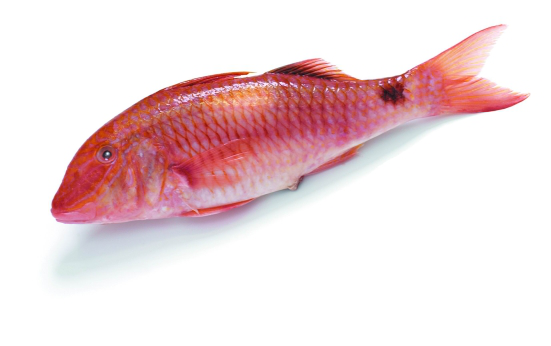

In [77]:
img

In [78]:
img = img.resize((224,224))

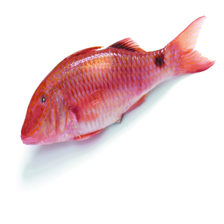

In [79]:
img

In [80]:
img = np.array(img)

In [83]:
img.dtype

dtype('uint8')

In [84]:
img.shape

(224, 224, 3)